# Final Project Submission

* Student name: Samuel Forrest Williams
* Student pace: full time
* Scheduled project review date/time: 5/12/2023
* Instructor name: Praveen Gowtham
* Blog post URL:

In [1]:
#Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib
import sqlite3
import matplotlib.pyplot as plt
import json
import pickle
import seaborn as sns
from copy import deepcopy

In [2]:
# Reading the CSV budget and production file from The Numbers
tn_movie_budgets = pd.read_csv('data/tn.movie_budgets.csv')

## SQL queries of IMDB database

In [3]:
con = sqlite3.connect('data/im.db')
cursor_obj = con.cursor()

In [5]:
# Connecting IMDB Tables-- 'movie_akas', 'movie_basics', and 'movie_ratings'
qr_movie_akas = 'SELECT B.movie_id, B.title, B.region, B.language, B.types, B.attributes, B.is_original_title, A.primary_title, A.original_title, A.start_year, A.runtime_minutes, A.genres, C.averagerating, C.numvotes FROM movie_akas B, movie_basics A, movie_ratings C WHERE B.movie_id=A.movie_id and B.movie_id=C.movie_id' #


In [6]:
# Reading the SQL data into a new table
tb_movie_akas = pd.read_sql(qr_movie_akas,con)

In [7]:
tb_movie_akas['genres']

0         Action,Adventure,Sci-Fi
1         Action,Adventure,Sci-Fi
2         Action,Adventure,Sci-Fi
3         Action,Adventure,Sci-Fi
4         Action,Adventure,Sci-Fi
                   ...           
261801    Action,Adventure,Comedy
261802    Action,Adventure,Comedy
261803              Music,Romance
261804              Music,Romance
261805              Music,Romance
Name: genres, Length: 261806, dtype: object

In [8]:
# Creating a new column with genre information as a list
tb_movie_akas['genres_split'] = tb_movie_akas['genres'].str.split(",")

In [9]:
tb_movie_akas['genres_split']

0         [Action, Adventure, Sci-Fi]
1         [Action, Adventure, Sci-Fi]
2         [Action, Adventure, Sci-Fi]
3         [Action, Adventure, Sci-Fi]
4         [Action, Adventure, Sci-Fi]
                     ...             
261801    [Action, Adventure, Comedy]
261802    [Action, Adventure, Comedy]
261803               [Music, Romance]
261804               [Music, Romance]
261805               [Music, Romance]
Name: genres_split, Length: 261806, dtype: object

In [10]:
#Removing row entries for Movie Titles which were not the original title
tb_movie_akas_tot = deepcopy(tb_movie_akas[tb_movie_akas['is_original_title'] == 1])

## Cleaning our financials information table from The Numbers™

In [11]:
tn_movie_budgets

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0


In [12]:
#Strip $-sign
tn_movie_budgets['production_budget'] = tn_movie_budgets['production_budget'].map(lambda x: x.strip('$'))
tn_movie_budgets['domestic_gross'] = tn_movie_budgets['domestic_gross'].map(lambda x: x.strip('$'))
tn_movie_budgets['worldwide_gross'] = tn_movie_budgets['worldwide_gross'].map(lambda x: x.strip('$'))

In [13]:
#Strip commas and convert value to a float
tn_movie_budgets['production_budget'] = tn_movie_budgets['production_budget'].map(lambda x: float(x.replace(",", "")))
tn_movie_budgets['domestic_gross'] = tn_movie_budgets['domestic_gross'].map(lambda x: float(x.replace(",", "")))
tn_movie_budgets['worldwide_gross'] = tn_movie_budgets['worldwide_gross'].map(lambda x: float(x.replace(",", "")))

In [14]:
#Creating Columns for Profit Information (Domestic Profit, Worldwide Profit, and Return on Investment- roi)
tn_movie_budgets['domestic_profit'] = tn_movie_budgets['domestic_gross'] - tn_movie_budgets['production_budget']
tn_movie_budgets['total_profit'] = tn_movie_budgets['worldwide_gross'] - tn_movie_budgets['production_budget']
tn_movie_budgets['roi'] = (tn_movie_budgets['worldwide_gross']-tn_movie_budgets['production_budget'])/tn_movie_budgets['production_budget']

In [16]:
## Removing movies before 2010

#convert to release_date columnt to datetime
tn_movie_budgets['release_date'] = pd.to_datetime(tn_movie_budgets['release_date'])
#set index to datetime
tn_movie_budgets.set_index('release_date', inplace=True)
#slice out our timeframe
recent_movie_budgets = deepcopy(tn_movie_budgets.sort_index().loc['01-01-2010':'12-31-2022'])
recent_movie_budgets.reset_index(inplace = True)

## Merging our datasets -- We will merge on both year and title

In [17]:
## From IMDB dataset
#Creating new column for year information as datetime
tb_movie_akas_tot['year'] = pd.to_datetime(tb_movie_akas_tot['start_year']).astype(int)

In [18]:
## From The Numbers dataset
recent_movie_budgets['year'] = recent_movie_budgets['release_date'].dt.year

In [19]:
## Merge -- (Also Removed Movies which had a worldwide gross of $0;
            #Sample Inspection showed movies which were not yet released at the time)
aka_movie = tb_movie_akas_tot.merge(recent_movie_budgets[recent_movie_budgets['worldwide_gross'] != 0],left_on=['title','year'],right_on=['movie','year'], how = 'inner')

## Initial Visualizations

/var/folders/bf/n_rprvk91ndgxz_bd75lz03h0000gp/T/ipykernel_91425/555206041.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['$0','$0', '$50M', '$100M', '$150M',


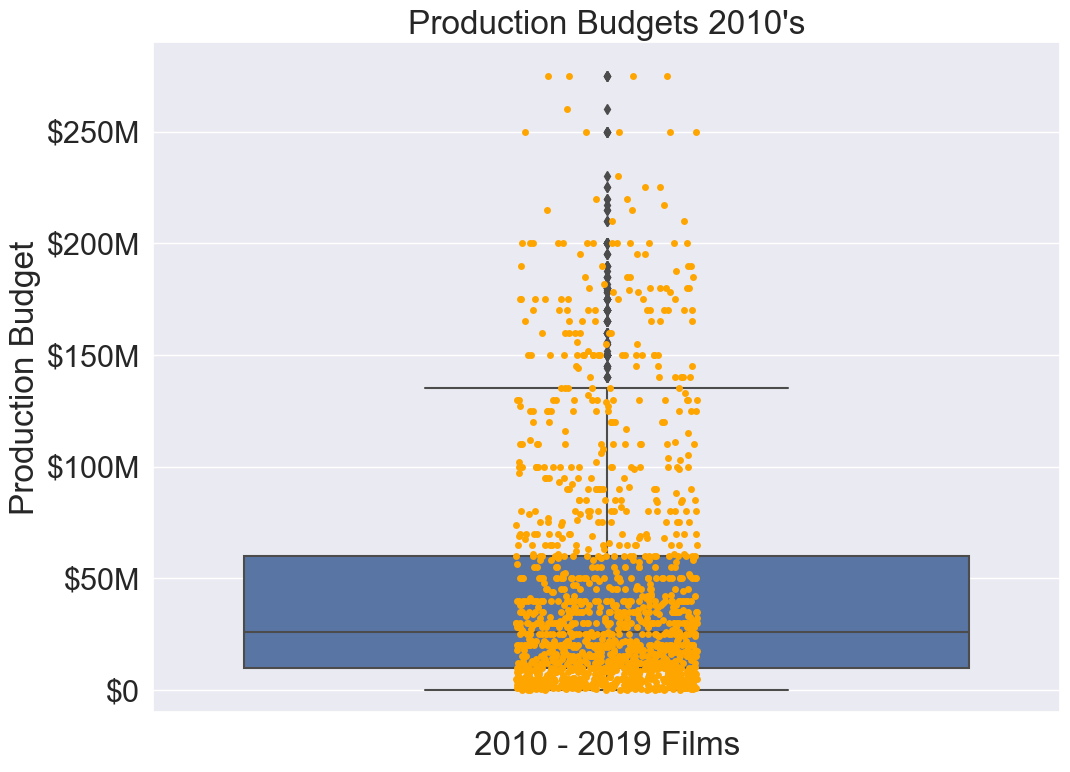

In [84]:
fig, ax = plt.subplots()

fig.set_size_inches(11.7, 8.7)
sns.boxplot(y = 'production_budget', data = aka_movie, ax = ax)
g = sns.stripplot(data=aka_movie['production_budget'], color = 'orange')
g.set(xlabel ="2010 - 2019 Films", ylabel = "Production Budget", title ="Production Budgets 2010's")
ax.set_yticklabels(['$0','$0', '$50M', '$100M', '$150M',
                   '$200M', '$250M'])
# ax.xlabel(fontsize=16);
# ax.ylabel(fontsize=16);
# ax.title(fontsize=20)
# change the limits of Y-axis
ax.set_ylim(-10000000, 290000000)
plt.show()


/var/folders/bf/n_rprvk91ndgxz_bd75lz03h0000gp/T/ipykernel_91425/1988288959.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['$0','$0', '$50M', '$100M', '$150M',


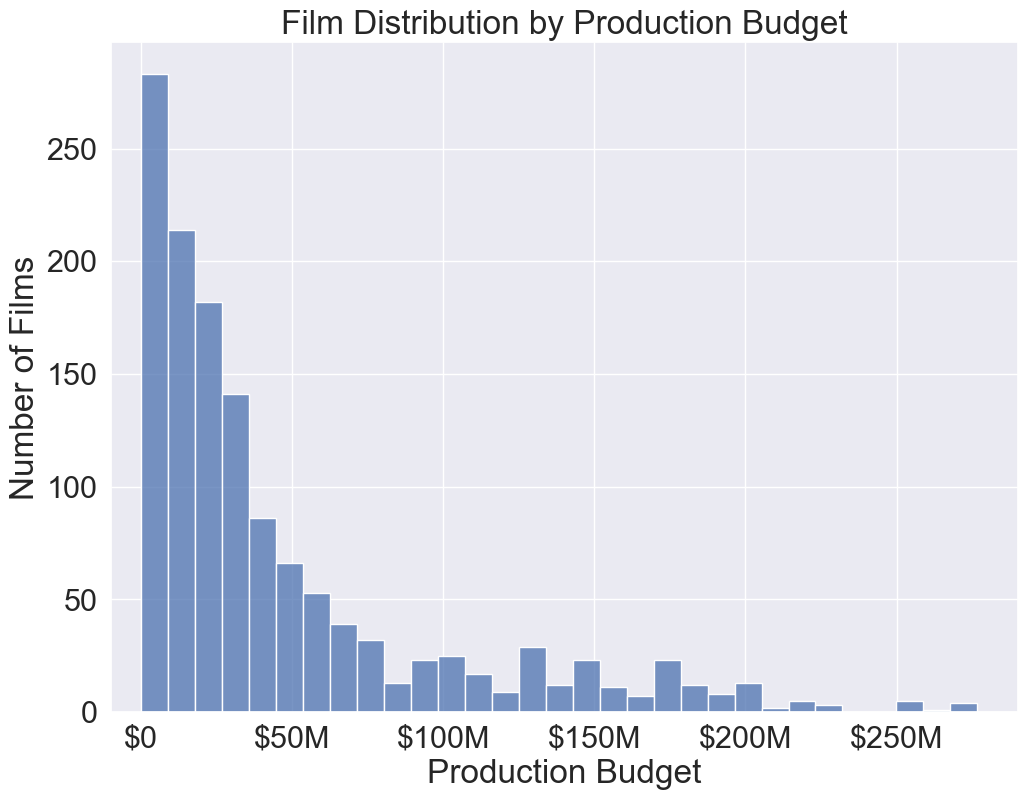

In [85]:
fig, ax = plt.subplots()

fig.set_size_inches(11.7, 8.7)
h = sns.histplot(data = aka_movie['production_budget'], ax = ax)
ax.set_xlim(-10000000, 290000000)
ax.set_xticklabels(['$0','$0', '$50M', '$100M', '$150M',
                   '$200M', '$250M'])


h.set(ylabel ="Number of Films", xlabel = "Production Budget", title ="Film Distribution by Production Budget")
plt.show()

## Tweaking dataset to extract categorical data

In [105]:
## Adding a new column to our main dataset that categorizes movies between percentiles
result = []
for value in aka_movie["production_budget"]:
    if value < 10000000.0:
        result.append("Low Budget")
    elif value > 10000000.0 and value < 26000000.0:
        result.append("Mid Budget")
    elif value > 26000000.0 and value < 60000000.0:
        result.append("Big Budget")
    else:
        result.append("Whopper")
aka_movie["budget_category"] = result

['Whopper', 'Whopper', 'Whopper', 'Whopper', 'Big Budget', 'Big Budget', 'Mid Budget', 'Whopper', 'Big Budget', 'Big Budget', 'Whopper', 'Mid Budget', 'Low Budget', 'Low Budget', 'Whopper', 'Mid Budget', 'Big Budget', 'Big Budget', 'Low Budget', 'Low Budget', 'Whopper', 'Mid Budget', 'Low Budget', 'Big Budget', 'Whopper', 'Whopper', 'Big Budget', 'Low Budget', 'Low Budget', 'Whopper', 'Whopper', 'Big Budget', 'Whopper', 'Whopper', 'Whopper', 'Big Budget', 'Big Budget', 'Whopper', 'Mid Budget', 'Whopper', 'Big Budget', 'Big Budget', 'Whopper', 'Low Budget', 'Whopper', 'Whopper', 'Whopper', 'Big Budget', 'Whopper', 'Big Budget', 'Whopper', 'Mid Budget', 'Whopper', 'Mid Budget', 'Low Budget', 'Whopper', 'Whopper', 'Big Budget', 'Mid Budget', 'Big Budget', 'Whopper', 'Whopper', 'Whopper', 'Big Budget', 'Mid Budget', 'Big Budget', 'Mid Budget', 'Whopper', 'Big Budget', 'Mid Budget', 'Whopper', 'Whopper', 'Big Budget', 'Big Budget', 'Whopper', 'Big Budget', 'Whopper', 'Mid Budget', 'Whopper'

In [108]:
## Exploding Genre Information Column to evaluate films with multiple genres
aka_movie_ex = aka_movie.explode('genres_split')

In [125]:
## Creating a list of the top 13 genres in all movies for filtering
top_genres = list(aka_movie_ex['genres_split'].value_counts().head(13).keys())

## Feelin' Risky? These are all the films with ROI > 10 or total profit > 05e9
cat1_cashcow = cat1_budgets[cat1_budgets['roi'] > 10]
cat2_cashcow = cat2_budgets[cat2_budgets['roi'] > 5]

In [147]:
## Making Lists of the Top Performing Movies by budget category (using aka_movie, not the exploded aka_movie_ex)
whopper_movies = list(aka_movie[aka_movie.budget_category=='Whopper'].sort_values(by = 'roi', ascending=False).head(40)['title'].values)
big_movies = list(aka_movie[aka_movie.budget_category=='Big Budget'].sort_values(by = 'roi', ascending=False).head(40)['title'].values)
mid_movies = list(aka_movie[aka_movie.budget_category=='Mid Budget'].sort_values(by = 'roi', ascending=False).head(40)['title'].values)
low_movies = list(aka_movie[aka_movie.budget_category=='Low Budget'].sort_values(by = 'roi', ascending=False).head(40)['title'].values)

In [149]:
## Making value counts on top performing movie genres (using exploded aka_movie_ex to capture multiple genre movies)
whopper_movie_genres = aka_movie_ex[aka_movie_ex['title'].isin(whopper_movies)]['genres_split'].value_counts()
big_movie_genres = aka_movie_ex[aka_movie_ex['title'].isin(big_movies)]['genres_split'].value_counts()
mid_movie_genres= aka_movie_ex[aka_movie_ex['title'].isin(mid_movies)]['genres_split'].value_counts()
low_movie_genres = aka_movie_ex[aka_movie_ex['title'].isin(low_movies)]['genres_split'].value_counts()

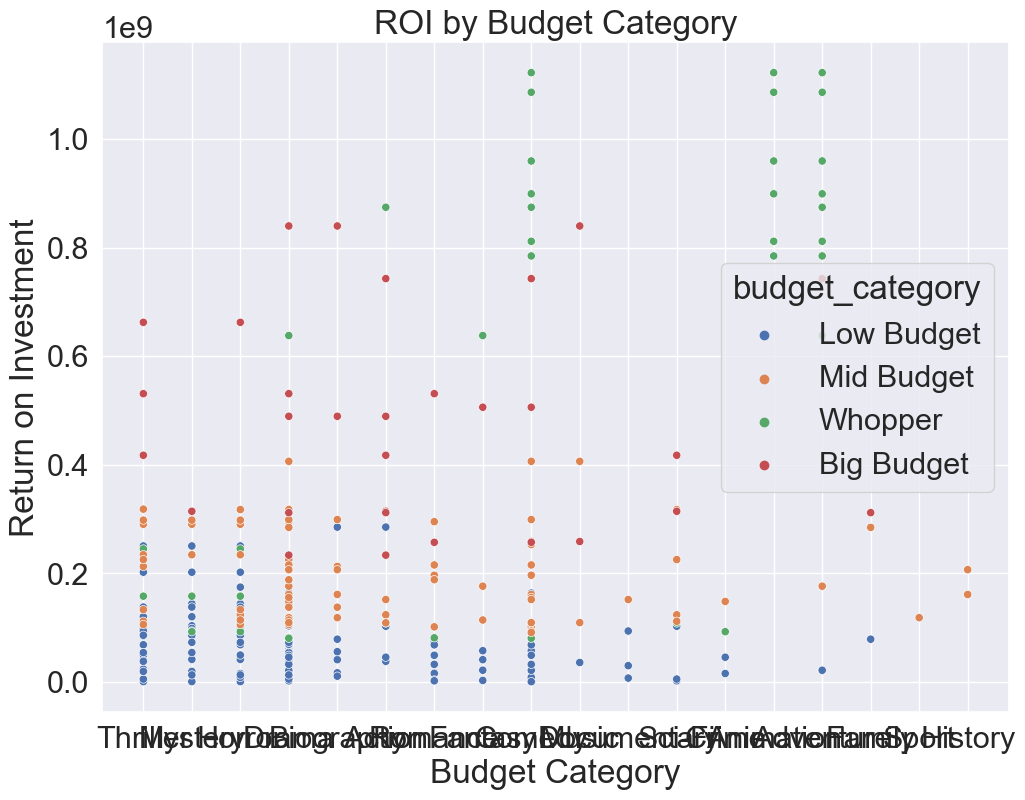

In [160]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.7)
j = sns.scatterplot(x = 'genres_split', y = 'total_profit', 
            data = aka_movie_ex.sort_values(by = 'roi', ascending=False).head(300), hue = 'budget_category')
j.set(xlabel ="Budget Category", ylabel = "Return on Investment", title ="ROI by Budget Category")
# ax.set_ylim(10, 50)
plt.show()

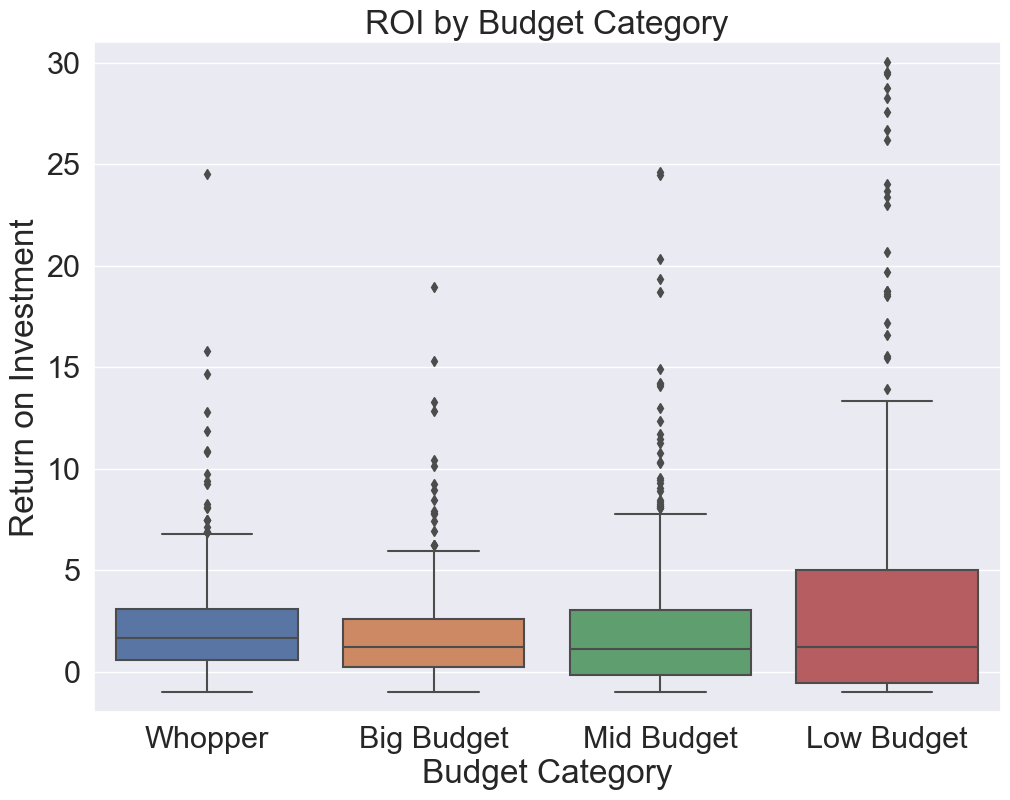

In [124]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.7)
j = sns.boxplot(x = 'budget_category', y = 'roi', 
            data = aka_movie, orient = 'v')
j.set(xlabel ="Budget Category", ylabel = "Return on Investment", title ="ROI by Budget Category")
ax.set_ylim(-2, 31)
plt.show()



# h.set(ylabel ="Number of Films", xlabel = "Production Budget", title ="Film Distribution by Production Budget")

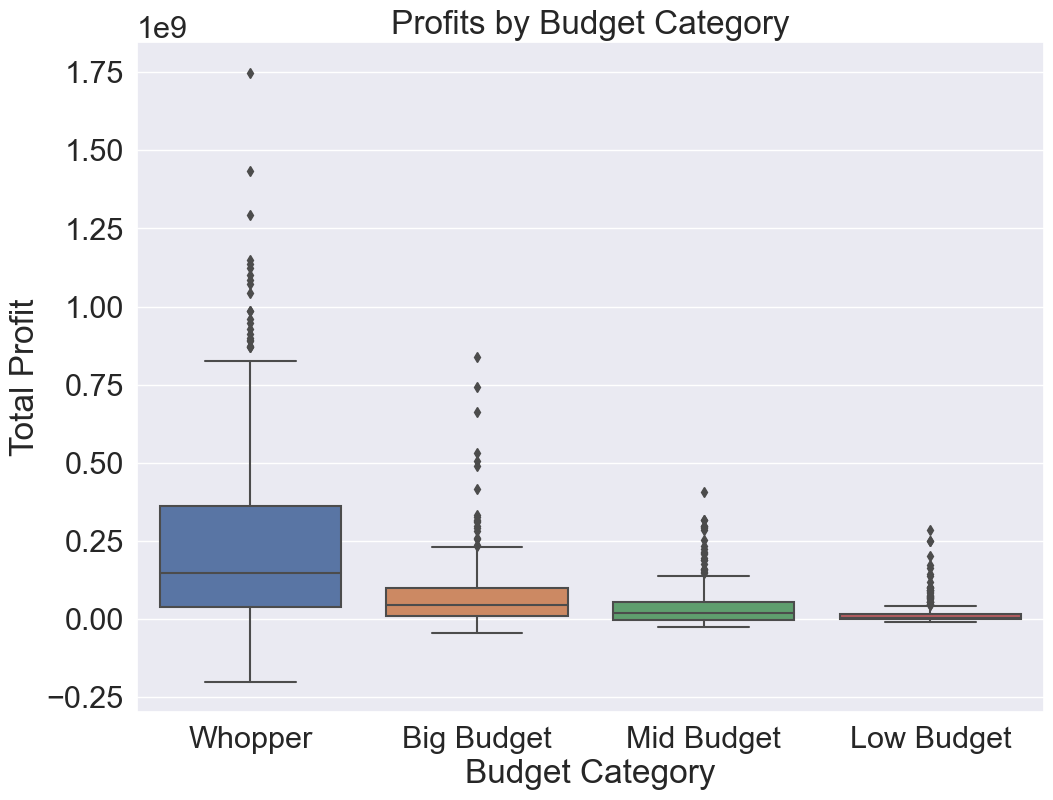

In [121]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.7)
k = sns.boxplot(x = 'budget_category', y = 'total_profit', 
            data = aka_movie, orient = 'v')
k.set(xlabel ="Budget Category", ylabel = "Total Profit", title ="Profits by Budget Category")

plt.show()
plt.show()